# DBLP dataset
---

*Source: https://www.aminer.org/citation*

We use the `V13` dataset. 
> The citation data is extracted from DBLP, ACM, MAG (Microsoft Academic Graph), and other sources.

We build the graph of citations, where each node represents a paper, a directed link between nodes represents a citation between papers. Moreover, we use words in the abstract of each paper as a vector of binary attributes for the corresponding nodes.

**Libraries**

In [4]:
from IPython.display import SVG

from collections import defaultdict, Counter
import ijson
import json
import numpy as np
import pickle
from scipy import sparse
from tqdm import tqdm

import nltk

from sknetwork.data import from_edge_list, Bunch, save
from sknetwork.topology import get_connected_components
from sknetwork.visualization import svg_graph

## 1. Load data

* `dblpv13.json` needs treatment before getting parsed. We use `sed s/NumberInt([0-9]*)/"ok"/g dblpv13.json >> dblpv14.json` in order to replace badly parsed Integers.

In [2]:
path = '/Users/simondelarue/Downloads/dblpv14.json'

In [5]:
%%time

categories = ['computer science']#, 'pattern recognition']
articles = {}
cpt = 0

with open(path, 'rb') as f:
    for record in tqdm(ijson.items(f, 'item')):
        # Add articles only if they have abstract + title + belong to defined category
        if 'fos' in record.keys() and 'abstract' in record.keys() and 'title' in record.keys() and 'references' in record.keys() and len(record.get('title')) > 0 and len(record.get('abstract')) > 0:
            for cat in record['fos']:
                if cat.lower() in categories:
                    articles[record['_id']] = {'name': record['title'],
                                      'abstract': record['abstract'],
                                      'categories': record['fos'],
                                      'references': record['references']}
                    cpt += 1
                    break

5354309it [20:39, 4318.03it/s] 

CPU times: user 20min 11s, sys: 25 s, total: 20min 36s
Wall time: 20min 40s


In [6]:
%%time
with open('data/dblpv13_raw.json', 'w') as f:
    json.dump(articles, f)

CPU times: user 26.8 s, sys: 4.28 s, total: 31.1 s
Wall time: 32.2 s


In [7]:
print(f'Number of raw articles: {len(articles)}')

Number of raw articles: 2121958


For each article, we go through its references and verify the validity of each of them, i.e if they belongs to the registered articles. If some references are not valid (meaning they do not belong to 'Computer Science' field, or their title and abstract are empty), we delete them from the list of references. We end with a dictionary of articles with:
* belong to `Computer Science` field
* non empty title
* non empty abstract
* references respecting the three previous criteria

In [67]:
%%time

# Remove non-valid articles from references
for article, values in tqdm(articles.items()):
    new_references = values.get('references').copy()
    for ref in values.get('references'):
        if ref not in articles:
            new_references.remove(ref)
    articles[article]['references'] = new_references

100%|███████████████████████████████████████████████████████| 2121958/2121958 [00:13<00:00, 152128.46it/s]

CPU times: user 10.9 s, sys: 2.39 s, total: 13.3 s
Wall time: 14 s


In [ ]:
%%time
with open('data/dblpv13.json', 'w') as f:
    json.dump(articles, f)

In [9]:
with open('data/dblpv13.json', 'r') as f:
    data = json.load(f)

#mydict = json.load('data/dblpv13.json')
#mydict

## Build graph dataset  

For each article, go through its references, if reference is registered in *valid* articles, i.e. articles with abstract + title + belongs to defined categories $\rightarrow$ saves corresponding edge in graph.

In [35]:
%%time

edges = []
id2idx = {}
idx = 0

for article, values in articles.items():
    if article not in id2idx:
        id2idx[article] = idx
        idx += 1
    for ref in values.get('references'):
        if ref not in id2idx:
            id2idx[ref] = idx
            idx += 1
        edges.append((id2idx.get(article), id2idx.get(ref)))

CPU times: user 32.5 s, sys: 20.9 s, total: 53.4 s
Wall time: 1min 14s


In [36]:
adjacency = from_edge_list(edges)

In [37]:
print(adjacency.shape)

(4177769, 4177769)


### Title as names

In [109]:
%%time

idx2titles = {}

for article, values in articles.items():
    idx2titles[id2idx.get(article)] = values.get('name')

CPU times: user 3.17 s, sys: 7.06 s, total: 10.2 s
Wall time: 25.8 s


In [112]:
names = np.array(list(dict(sorted(idx2titles.items(), key=lambda x: x[0])).values()))

In [113]:
names[:10]

array(['A solution to the problem of touching and broken characters.',
       'Reading cursive handwriting by alignment of letter prototypes',
       'Direct gray-scale extraction of features for character recognition',
       'The relative neighbourhood graph of a finite planar set',
       'The Relative Neighborhood Graph, with an Application to Minimum Spanning Trees',
       'A shape analysis model with applications to a character recognition system',
       'Timing yield estimation using statistical static timing analysis',
       'Statistical Timing Analysis Considering Spatial Correlations using a Single Pert-Like Traversal',
       'A new statistical approach to timing analysis of VLSI circuits',
       'Computation and Refinement of Statistical Bounds on Circuit Delay'],
      dtype='<U1926')

In [116]:
len(names)

3727418

In [117]:
len(id2idx)

4177769

In [115]:
for i in range(10):
    print(i, idx2titles.get(i))

0 A solution to the problem of touching and broken characters.
1 Reading cursive handwriting by alignment of letter prototypes
2 Direct gray-scale extraction of features for character recognition
3 The relative neighbourhood graph of a finite planar set
4 The Relative Neighborhood Graph, with an Application to Minimum Spanning Trees
5 A shape analysis model with applications to a character recognition system
6 Timing yield estimation using statistical static timing analysis
7 Statistical Timing Analysis Considering Spatial Correlations using a Single Pert-Like Traversal
8 None
9 A new statistical approach to timing analysis of VLSI circuits


### Biadjacency

In [57]:
import re

In [59]:
articles.get('53e99cf5b7602d97025ace63').get('abstract')

'We describe a new approach to the visual recognition of cursive handwriting. An effort is made to attain human- like performance by using a method based on pictorial alignment and on a model of the process of handwriting. The alignment approach permits recognition of character instances that appear embedded in connected strings. A system embodying this approach has been implemented and tested on five different word sets. The performance was stable both across words and across writers. The system exhibited a substantial ability to interpret cursive connected strings without recourse to lexical knowledge. The interpretation of cursive connected handwriting is considerably more difficult than the reading of printed text. This difficulty may be the reason for the relative lack of attention to the problem of reading cursive script within the field of computational vision. The present article describes progress made toward understanding and solving this problem. We identify and discuss two 

In [70]:
def tokenize_text(text):
    """ Merge words that have been cut + remove punctuation + tokenize """
    res = re.sub(r'- ', '', text)
    res_without_punc = re.sub(r'[^\w\s]', '', res)
    tokens = nltk.word_tokenize(res_without_punc)
    return tokens

In [91]:
%%time

# Create indexed list of words from abstracts
words2idx = {}
idx = 0

for article, values in articles.items():
    abstract = values.get('abstract')
    tokens = tokenize_text(abstract)
    for tk in tokens:
        if tk not in words2idx:
            words2idx[tk] = idx
            idx += 1

CPU times: user 15min 41s, sys: 13.3 s, total: 15min 55s
Wall time: 16min 17s


In [92]:
print(len(words2idx))

2890817


In [93]:
%%time
idx2words = {v: k for k, v in words2idx.items()}

CPU times: user 119 ms, sys: 141 ms, total: 260 ms
Wall time: 360 ms


In [98]:
biadjacency = sparse.csr_matrix((len(id2idx), len(words2idx)))

In [102]:
biadjacency

<4177769x2890817 sparse matrix of type '<class 'numpy.float64'>'
	with 2413138 stored elements in Compressed Sparse Row format>

In [ ]:
%%time

# Fill biadjacency matrix
for article, values in articles.items():
    abstract = values.get('abstract')
    tokens = tokenize_text(abstract)
    for tk in tokens:
        biadjacency[id2idx.get(article), words2idx.get(tk)] += 1

In [38]:
adjacency.nnz

89221038

In [41]:
labels_cc = get_connected_components(adjacency)

In [42]:
len(np.unique(labels_cc))

10251

In [48]:
sorted(Counter(labels_cc).items(), key=lambda x: x[1], reverse=True)[:10]

[(0, 4153176),
 (623, 29),
 (342, 19),
 (1772, 17),
 (1000, 15),
 (5109, 15),
 (496, 12),
 (527, 12),
 (773, 12),
 (2433, 12)]

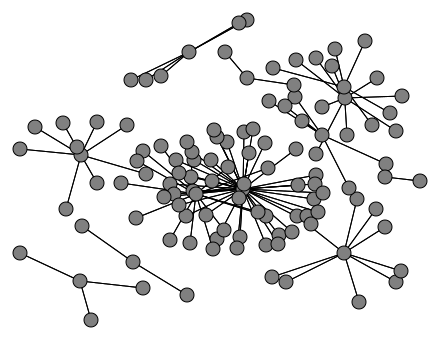

In [34]:
SVG(svg_graph(graph))

## Save data

In [106]:
names_col = np.array(list(words2idx.keys()))
names = 

array(['As', 'process', 'variations', 'become', 'a', 'significant',
       'problem', 'in', 'deep', 'submicron'], dtype='<U3992')

In [ ]:
dataset = Bunch()
dataset.adjacency = adjacency
dataset.biadjacency = biadjacency
dataset.names = names
dataset.names_col = names_col

meta = Bunch()
meta.name = "Baboon\'s interactions on 13/06/2019."
meta.description = 'Links connecting baboons between each other if they interacted at least once on 13/06/2019.'
meta.source = 'http://www.sociopatterns.org/datasets/baboons-interactions/'
meta.date = 'October 2022'
dataset.meta = meta